Cкачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2021-05-18 10:46:32--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2021-05-18 10:46:32--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6b11ba20b520d681297b5edc21.dl.dropboxusercontent.com/cd/0/inline/BOtzja4jgOC6grHD5nRXjhKZvWRbrZ57irPXzoy-O_CSyZbWekhTYasKwll7os-aYQu1dAOlZdRMNVzysDiZHLX5LZxEPni1JUx5L17bfqZET13itf7LKmC59jba0_AWsMbHOy4Z4fb6t0MYNgi2YKev/file# [following]
--2021-05-18 10:46:32--  https://uc6b11ba20b520d681297b5edc21.dl.dropboxusercontent.com/cd/0/inline/BOtzja4jgOC6grHD5nRXjhKZvWRbrZ57irPXzoy-O_CSyZbWekhTYasKwll7os-aYQu1dAOlZdRMNVzysDiZ

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

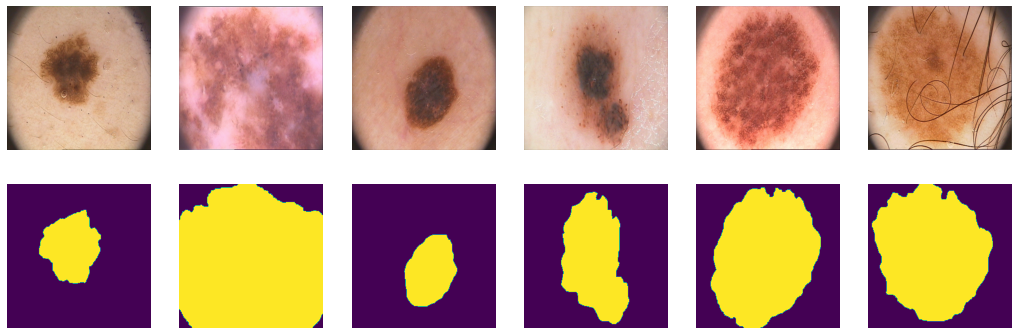

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


## DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# SEGNET

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
def two_env_conv(input_channels,output_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(output_channels),
      nn.ReLU(),

      nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(output_channels),
      nn.ReLU()
    )

In [ ]:
def three_env_conv(input_channels,output_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(output_channels),
      nn.ReLU(),

      nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(output_channels),
      nn.ReLU(),

      nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(output_channels),
      nn.ReLU()
    )

In [ ]:
def three_dec_conv(input_channels,output_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels=input_channels, out_channels=input_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(input_channels),
      nn.ReLU(),

      nn.Conv2d(in_channels=input_channels, out_channels=input_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(input_channels),
      nn.ReLU(),

      nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(output_channels),
      nn.ReLU()
    )

In [ ]:
def two_dec_conv(input_channels,output_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels=input_channels, out_channels=input_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(input_channels),
      nn.ReLU(),

      nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(output_channels),
      nn.ReLU()
    )

In [ ]:
def botl_ConvTranspose2d(input_channels,output_channels):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(output_channels),
      nn.ReLU(),

      nn.ConvTranspose2d(in_channels=output_channels, out_channels=output_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(output_channels),
      nn.ReLU(),

      nn.ConvTranspose2d(in_channels=output_channels, out_channels=output_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(output_channels),
      nn.ReLU()
    ) 

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = two_env_conv(3,64)
        self.enc_conv1 = two_env_conv(64,128)
        self.enc_conv2 = three_env_conv(128,256)
        self.enc_conv3 = three_env_conv(256,512)
        self.enc_conv4 = three_env_conv(512,1024)        

        # bottleneck
        self.bottleneck_conv = three_env_conv(1024,1024)
        self.bottleneck_convTranspose2d = botl_ConvTranspose2d(1024,1024)

        # decoder (upsampling)
        self.dec_conv0 = three_dec_conv(1024,512)
        self.dec_conv1 = three_dec_conv(512,256)
        self.dec_conv2 = three_dec_conv(256,128)
        self.dec_conv3 = two_dec_conv(128,64)
        self.dec_conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=(3, 3), padding=1)
            )

        self.pool = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x):
        # encoder
        e0, i0 = self.pool(self.enc_conv0(x))
        e1, i1 = self.pool(self.enc_conv1(e0))
        e2, i2 = self.pool(self.enc_conv2(e1))
        e3, i3 = self.pool(self.enc_conv3(e2))
        e4, i4 = self.pool(self.enc_conv4(e3))

        # bottleneck
        b0, i5 = self.pool(self.bottleneck_conv(e4))
        b1 = self.bottleneck_convTranspose2d(self.unpool(b0, i5))

        # decoder
        d0 = self.dec_conv0(self.unpool(b1, i4))
        d1 = self.dec_conv1(self.unpool(d0, i3))
        d2 = self.dec_conv2(self.unpool(d1, i2))
        d3 = self.dec_conv3(self.unpool(d2, i1))
        d4 = self.dec_conv4(self.unpool(d3, i0)) # no activation
        return d4

In [ ]:
import torchsummary

torchsummary.summary(SegNet().to(device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14  [[

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

In [ ]:
losses = {}

In [ ]:
losses = {'segnet_bce' : [], 'segnet_dice': [], 'segnet_focal': [], 'segnet_tversky': [], 'unet_bce': [], 'unet_dice': [], 'unet_focal': [], 'unet_tversky': [], 'unet2_bce': [], 'unet2_dice': [], 'unet2_focal': [], 'unet2_tversky': []}


In [ ]:
scores = {'segnet_bce': 0., 'segnet_dice': 0., 'segnet_focal': 0., 'segnet_tversky': 0., 'unet_bce': 0., 'unet_dice': 0., 'unet_focal': 0., 'unet_tversky': 0., 'unet2_bce': 0., 'unet2_dice': 0., 'unet2_focal': 0., 'unet2_tversky': 0.}


In [ ]:
losses_one = []

In [ ]:
def bce_loss(y_real, y_pred):
    # TODO 
  return (torch.clamp(y_pred, 0) - y_pred * y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))).mean()

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, data_test = None):
    X_val, Y_val = next(iter(data_val))
    val_losses = []
    train_losses = []
    score = []
    test_score = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_pred = model(X_batch)
            #print(Y_pred)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            #print(Y_pred)
            #loss = loss_fn(Y_pred, Y_batch.to(device))
            loss = loss_fn(Y_batch.to(device), Y_pred).mean()
            #print(loss)
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        train_losses.append(avg_loss)

        toc = time()
        print('loss: %f' % avg_loss)
        # losses_one.append(round(avg_loss.item(), 3))
        # show intermediate results
        avg_loss = 0
        model.eval()  # testing mode
        with torch.no_grad():
            for X_batch, Y_batch in data_val:
                
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                Y_pred = model(X_batch)
                loss = loss_fn(Y_batch, Y_pred)
                avg_loss += loss.item() / len(data_val)
            val_losses.append(avg_loss)

        score.append(score_model(model, iou_pytorch, data_val))
        if data_test:
            test_score.append(score_model(model, iou_pytorch, data_test))
                
        Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu
        #print("test mode pred")
        Y_hat = torch.where(Y_hat > 0.5, 1, 0)

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return {'val':val_losses,'train':train_losses, 'test':test_score, 'score' : score}

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    # with torch.no_grad():
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        Y_pred = torch.where(Y_pred > 0.5, 1, 0)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores/len(data)

In [ ]:
import gc
data_tr = None
data_val = None
data_ts = None
gc.collect()
torch.cuda.empty_cache()
batch_size = 15
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
losses['unet2_bce']

{'score': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'test': [],
 'train': [tensor(0.6955, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.6955, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.6954, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.6954, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.6955, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.6956, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.6955, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.6954, device='cuda:0', grad_fn=<AddBackward0>),
  tens

In [ ]:
model = SegNet().to(device)

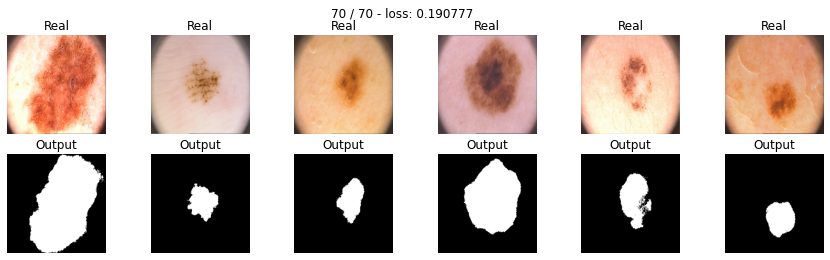

In [ ]:
max_epochs = 70
optimizer = torch.optim.Adam(model.parameters(),  lr = 1e-4)
losses['segnet_bce']=train(model, optimizer, bce_loss, max_epochs, data_tr, data_val, data_test=data_ts)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.6483333557844162

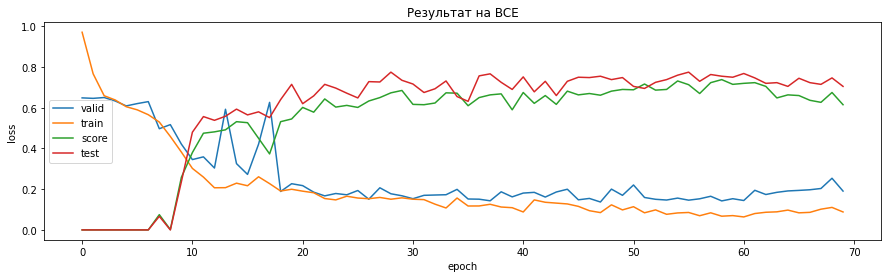

In [ ]:
fig, ax = plt.subplots()
plt.plot(range(len(losses['segnet_bce']['val'])),losses['segnet_bce']['val'], label='valid')
plt.plot(range(len(losses['segnet_bce']['train'])),losses['segnet_bce']['train'], label='train')
plt.plot(range(len(losses['segnet_bce']['score'])),losses['segnet_bce']['score'], label='score')
plt.plot(range(len(losses['segnet_bce']['test'])),losses['segnet_bce']['test'], label='test')
plt.legend()
plt.title('Результат BCE ')
ax.set(xlabel='epoch', ylabel='loss',  title='Результат на BCE')
plt.show()

In [ ]:
def dice_loss(y_true, y_pred_logits, eps = 1e-8):
    y_pred = torch.sigmoid(y_pred_logits)
    num = (y_true*y_pred).sum(dim=(2,3))
    den = y_true.sum(dim=(2,3))+y_pred.pow(2).sum(dim=(2,3)) + eps
    return 1 - (num/den).mean()    

Проводим тестирование:

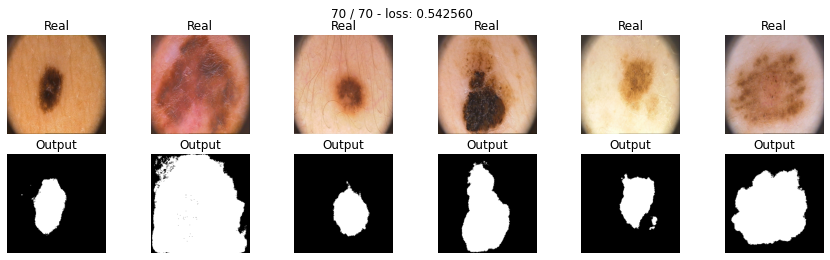

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 70
optimaizer = torch.optim.Adam(model_dice.parameters(), lr = 1e-4)
losses['seg_dice'] = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, data_test=data_ts)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.656666710972786

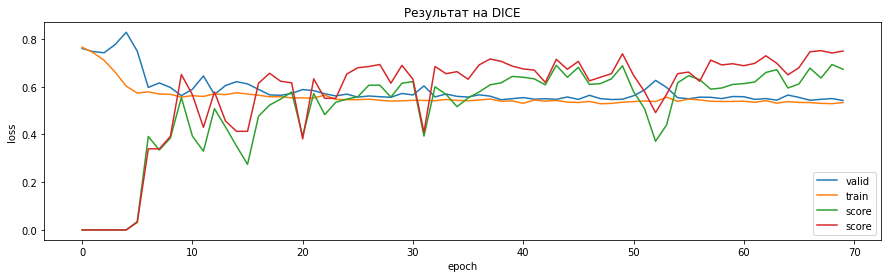

In [ ]:
fig, ax = plt.subplots()
plt.plot(range(len(losses['seg_dice']['val'])),losses['seg_dice']['val'], label='valid')
plt.plot(range(len(losses['seg_dice']['train'])),losses['seg_dice']['train'], label='train')
plt.plot(range(len(losses['seg_dice']['score'])),losses['seg_dice']['score'], label='score')
plt.plot(range(len(losses['seg_dice']['test'])),losses['seg_dice']['test'], label='score')
plt.legend()
plt.title('Результат DICE ')
ax.set(xlabel='epoch', ylabel='loss',  title='Результат на DICE')
plt.show()

In [ ]:
import gc
data_tr = None
data_val = None
data_ts = None
gc.collect()

batch_size = 15
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
def tversky_loss(y_true, y_pred_logits, eps = 1e-8, beta=0.5):
    y_pred = torch.sigmoid(y_pred_logits)
    intersection = (y_true*y_pred).sum(dim=(2,3))
    num = intersection
    fp = (beta*(1-y_true)*y_pred).sum(dim=(2,3))
    fn = ((1-beta)*y_true*(1-y_pred)).sum(dim=(2,3))
    den = intersection + fp + fn + eps
    return 1-(num/den).mean()

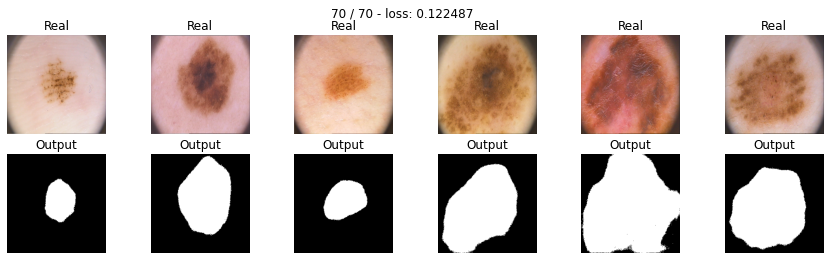

In [ ]:
model_tversky = SegNet().to(device)


optimaizer = torch.optim.Adam(model_tversky.parameters(), lr=0.00001)
losses['seg_tversky']=train(model_tversky, optimaizer, tversky_loss, max_epochs, data_tr, data_val, data_test=data_ts)

In [ ]:
score_model(model_tversky, iou_pytorch, data_val)

0.6150000244379044

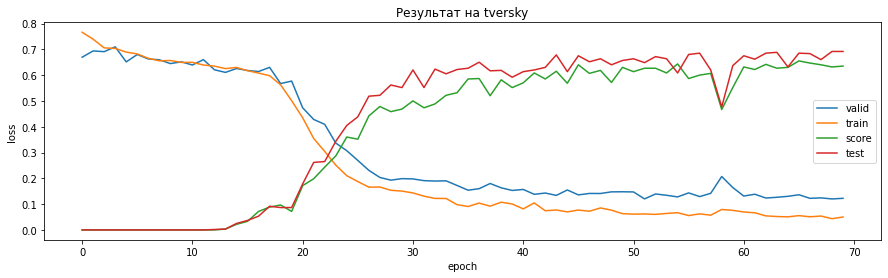

In [ ]:
fig, ax = plt.subplots()
plt.plot(range(len(losses['seg_tversky']['val'])),losses['seg_tversky']['val'], label='valid')
plt.plot(range(len(losses['seg_tversky']['train'])),losses['seg_tversky']['train'], label='train')
plt.plot(range(len(losses['seg_tversky']['score'])),losses['seg_tversky']['score'], label='score')
plt.plot(range(len(losses['seg_tversky']['test'])),losses['seg_tversky']['test'], label='test')
plt.legend()
plt.title('Результат tversky')
ax.set(xlabel='epoch', ylabel='loss',  title='Результат на tversky')
plt.show()

# U-NET

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.activation = nn.ReLU()
        
        # encoder (downsampling)
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(32),
            self.activation,
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(32),                                        
            self.activation)
        
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # h,w 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(64),
            self.activation,
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
             nn.BatchNorm2d(64),                                        
            self.activation)

        self.pool1 =  nn.MaxPool2d(kernel_size=2, return_indices=True) # h,w 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(128),
            self.activation,
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(128),                                        
            self.activation,
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(128),                                        
            self.activation)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # h,w 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(256),
            self.activation,
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(256),                                        
            self.activation,
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(256),                                        
            self.activation)

        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # h,w 32 -> 16

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(256),
            self.activation,
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(256),
            self.activation,
            
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(128),
            self.activation)
                                       
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # h,w 32 -> 64
        
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(128),
            self.activation,
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(128),
            self.activation,
            
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(64),
            self.activation)
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # h,w 64 -> 128
        
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(64),
            self.activation,
            
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(32),
            self.activation)
        
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # h,w 128 -> 256
        
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.BatchNorm2d(32),
            self.activation,
            
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1, padding_mode='zeros'))
        
        
        

    def forward(self, x):
        # note that activations are inside of self.xxx_convx
        
        # encoder
        enc0, indices_0 = self.pool0(self.enc_conv0(x))
        enc1, indices_1 = self.pool1(self.enc_conv1(enc0))
        enc2, indices_2 = self.pool2(self.enc_conv2(enc1))
        enc3, indices_3 = self.pool3(self.enc_conv3(enc2))

        # decoder
        dec0 = self.dec_conv0(self.upsample0(enc3, indices_3))
        dec1 = self.dec_conv1(self.upsample1(dec0, indices_2))
        dec2 = self.dec_conv2(self.upsample2(dec1, indices_1))
        dec3 = self.dec_conv3(self.upsample3(dec2, indices_0))
        
        return dec3

In [ ]:
class UNet(Net):
    
    def __init__(self):
        
        super().__init__()
        
        # add bottleneck
        
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            self.activation,
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            self.activation,
            
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            self.activation)
        
        # change the in_channels for the first layers in each level because of the new skip connections
        self.dec_conv0[0] = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.dec_conv1[0] = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.dec_conv2[0] = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.dec_conv3[0] = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        
    def forward(self, x):
        
        # encoder
        enc0_raw = self.enc_conv0(x)
        enc0, indices_0 = self.pool0(enc0_raw)
        
        enc1_raw = self.enc_conv1(enc0)
        enc1, indices_1 = self.pool1(enc1_raw)
        
        enc2_raw = self.enc_conv2(enc1)
        enc2, indices_2 = self.pool2(enc2_raw)
        
        enc3_raw = self.enc_conv3(enc2)
        enc3, indices_3 = self.pool3(enc3_raw)

        # bottleneck
        bottleneck = self.bottleneck_conv(enc3)
        
        # decoder
        dec0 = self.dec_conv0(torch.cat((self.upsample0(bottleneck, indices_3), enc3_raw), dim=1))
        dec1 = self.dec_conv1(torch.cat((self.upsample1(dec0, indices_2), enc2_raw), dim=1))
        dec2 = self.dec_conv2(torch.cat((self.upsample2(dec1, indices_1), enc1_raw), dim=1))
        dec3 = self.dec_conv3(torch.cat((self.upsample3(dec2, indices_0), enc0_raw), dim=1))
        
        
        
        return dec3

In [ ]:
import torchsummary
torchsummary.summary(UNet().to(device), input_size=(3, 256, 256))

In [ ]:
unet_model = UNet().to(device)

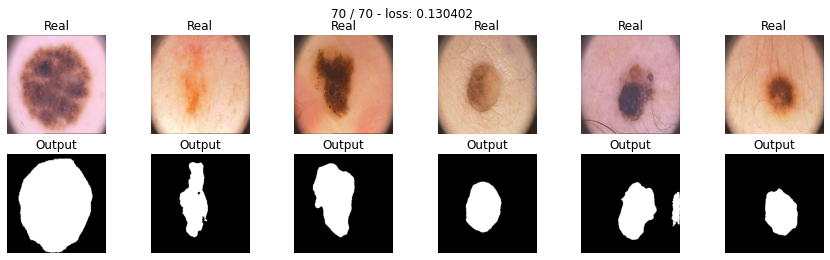

In [ ]:
num_epochs = 70
optimaizer = torch.optim.Adam(unet_model.parameters(), lr=0.0001)

losses['unet_bce'] = train(unet_model, optimaizer, bce_loss, num_epochs, data_tr, data_val, data_test=data_ts)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.7533333897590637

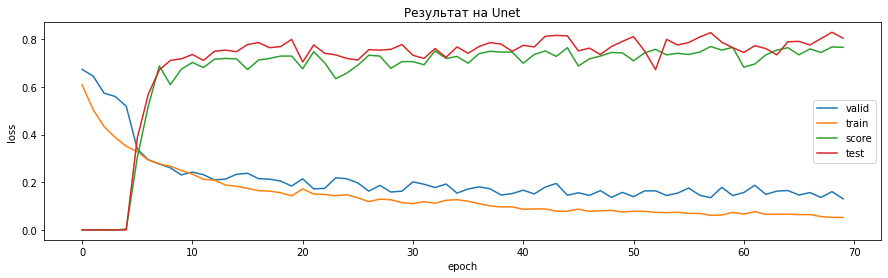

In [ ]:
fig, ax = plt.subplots()
plt.plot(range(len(losses['unet_bce']['val'])),losses['unet_bce']['val'], label='valid')
plt.plot(range(len(losses['unet_bce']['train'])),losses['unet_bce']['train'], label='train')
plt.plot(range(len(losses['unet_bce']['score'])),losses['unet_bce']['score'], label='score')
plt.plot(range(len(losses['unet_bce']['test'])),losses['unet_bce']['test'], label='test')
plt.legend()
plt.title('Результат Unet ')
ax.set(xlabel='epoch', ylabel='loss',  title='Результат на Unet')
plt.show()

In [ ]:
class UNet2(UNet):
    
    def __init__(self):
        
        super().__init__()
        
        self.pool0 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, padding_mode='zeros')  # 256 -> 128
        self.pool1 =  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, padding_mode='zeros') # 128 -> 64
        self.pool2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, padding_mode='zeros') # 64 -> 32
        self.pool3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, padding_mode='zeros') # 32 -> 16

        self.upsample0 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1, padding_mode='zeros') # 16 -> 32
        self.upsample1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, padding_mode='zeros') # 32 -> 64
        self.upsample2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1, padding_mode='zeros')  # 64 -> 128
        self.upsample3 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1, padding_mode='zeros')  # 128 -> 256
        
    def forward(self, x):

        enc0_raw = self.enc_conv0(x)
        enc0 = self.pool0(enc0_raw)
        enc1_raw = self.enc_conv1(enc0)
        enc1 = self.pool1(enc1_raw)
        enc2_raw = self.enc_conv2(enc1)
        enc2 = self.pool2(enc2_raw)
        enc3_raw = self.enc_conv3(enc2)
        enc3 = self.pool3(enc3_raw)
        bottleneck = self.bottleneck_conv(enc3)
        dec0 = self.dec_conv0(torch.cat((self.upsample0(bottleneck), enc3_raw), dim=1))
        dec1 = self.dec_conv1(torch.cat((self.upsample1(dec0), enc2_raw), dim=1))
        dec2 = self.dec_conv2(torch.cat((self.upsample2(dec1), enc1_raw), dim=1))
        dec3 = self.dec_conv3(torch.cat((self.upsample3(dec2), enc0_raw), dim=1))
        

In [ ]:
torchsummary.summary(UNet2().to(device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
              ReLU-4         [-1, 32, 256, 256]               0
              ReLU-5         [-1, 32, 256, 256]               0
              ReLU-6         [-1, 32, 256, 256]               0
              ReLU-7         [-1, 32, 256, 256]               0
              ReLU-8         [-1, 32, 256, 256]               0
              ReLU-9         [-1, 32, 256, 256]               0
             ReLU-10         [-1, 32, 256, 256]               0
             ReLU-11         [-1, 32, 256, 256]               0
             ReLU-12         [-1, 32, 256, 256]               0
           Conv2d-13         [-1, 32, 256, 256]           9,248
      BatchNorm2d-14         [-1, 32, 2

In [ ]:
unet2_model = UNet2().to(device)


In [ ]:
num_epochs = 10
optimaizer = torch.optim.Adam(unet_model.parameters(), lr=0.001)
losses['unet2_dice']=train(unet2_model, optimaizer, dice_loss,num_epochs, data_tr, data_val, data_test=data_ts)

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

In [ ]:
fig, ax = plt.subplots()
plt.plot(range(len(losses['unet2_bce']['val'])),losses['unet2_bce']['val'], label='valid')
plt.plot(range(len(losses['unet2_bce']['train'])),losses['unet2_bce']['train'], label='train')
plt.plot(range(len(losses['unet2_bce']['score'])),losses['unet2_bce']['score'], label='score')
plt.plot(range(len(losses['unet2_bce']['test'])),losses['unet2_bce']['test'], label='test')
plt.legend()
plt.title('Результат Unet2')
ax.set(xlabel='epoch', ylabel='loss',  title='Результат на Unet2')
plt.show()

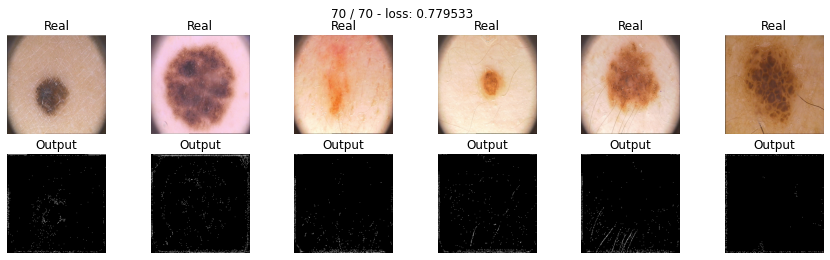

In [ ]:
unet_dice = UNet().to(device)
num_epochs = 70
optimaizer = torch.optim.Adam(unet_model.parameters(), lr=0.0001)
losses['unet_dice']=train(unet_dice, optimaizer, dice_loss, num_epochs, data_tr, data_val, data_test=data_ts)

In [ ]:
score_model(unet_dice, iou_pytorch, data_val)

0.0

Были использованы две модели:
1. SegNet
2. UNet (UNet2 - подкласс класса Unet)

И три лосса:
1. BCE
2. DICE
3. FOVAL
4. tversky

Были проведены исследования моделей на переобучение с увеличеснием эпох

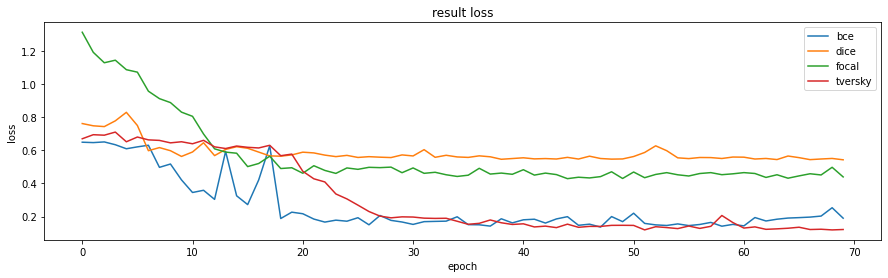

In [ ]:
  fig, ax = plt.subplots()
  plt.plot(range(len(losses['segnet_bce']['val'])),losses['segnet_bce']['val'], label='bce')
  plt.plot(range(len(losses['seg_dice']['val'])),losses['seg_dice']['val'], label='dice')
  plt.plot(range(len(losses['seg_foval']['val'])),losses['seg_foval']['val'], label='focal')
  plt.plot(range(len(losses['seg_tversky']['val'])),losses['seg_tversky']['val'], label='tversky')
  plt.legend()
  ax.set(xlabel='epoch', ylabel='loss',  title='result loss')
  plt.show()


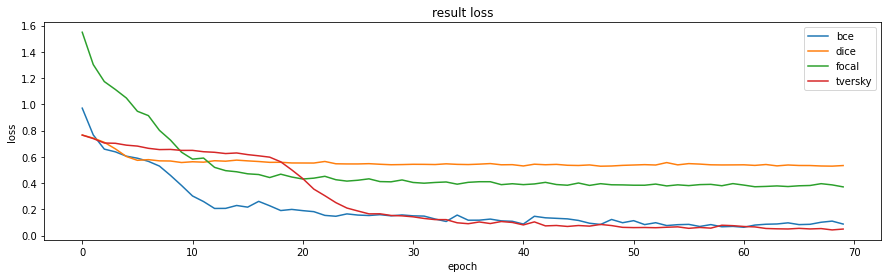

In [ ]:
  fig, ax = plt.subplots()
  plt.plot(range(len(losses['segnet_bce']['train'])),losses['segnet_bce']['train'], label='bce')
  plt.plot(range(len(losses['seg_dice']['train'])),losses['seg_dice']['train'], label='dice')
  plt.plot(range(len(losses['seg_foval']['train'])),losses['seg_foval']['train'], label='focal')
  plt.plot(range(len(losses['seg_tversky']['train'])),losses['seg_tversky']['train'], label='tversky')
  plt.legend()
  ax.set(xlabel='epoch', ylabel='loss',  title='result loss')
  plt.show()


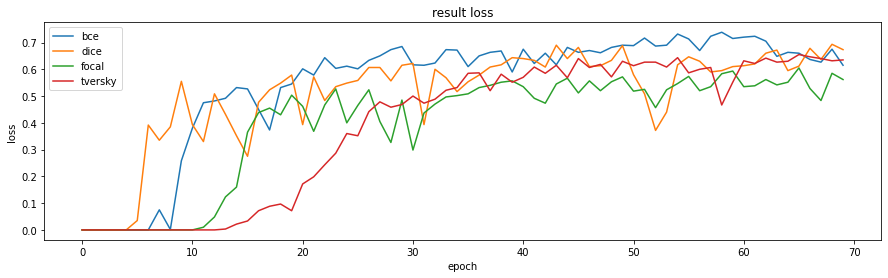

In [ ]:
  fig, ax = plt.subplots()
  plt.plot(range(len(losses['segnet_bce']['score'])),losses['segnet_bce']['score'], label='bce')
  plt.plot(range(len(losses['seg_dice']['score'])),losses['seg_dice']['score'], label='dice')
  plt.plot(range(len(losses['seg_foval']['score'])),losses['seg_foval']['score'], label='focal')
  plt.plot(range(len(losses['seg_tversky']['score'])),losses['seg_tversky']['score'], label='tversky')
  plt.legend()
  ax.set(xlabel='epoch', ylabel='loss',  title='result loss')
  plt.show()

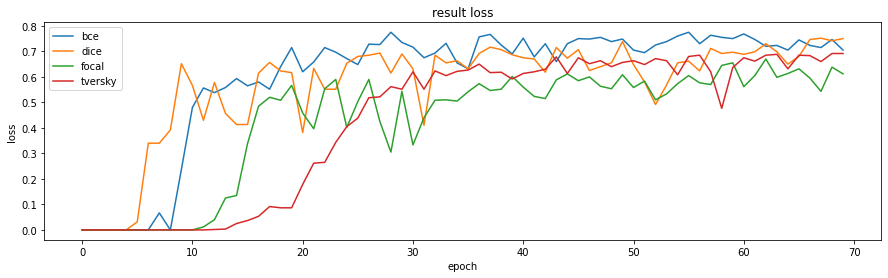

In [ ]:
  fig, ax = plt.subplots()
  plt.plot(range(len(losses['segnet_bce']['test'])),losses['segnet_bce']['test'], label='bce')
  plt.plot(range(len(losses['seg_dice']['test'])),losses['seg_dice']['test'], label='dice')
  plt.plot(range(len(losses['seg_foval']['test'])),losses['seg_foval']['test'], label='focal')
  plt.plot(range(len(losses['seg_tversky']['test'])),losses['seg_tversky']['test'], label='tversky')
  plt.legend()
  ax.set(xlabel='epoch', ylabel='loss',  title='result loss')
  plt.show()

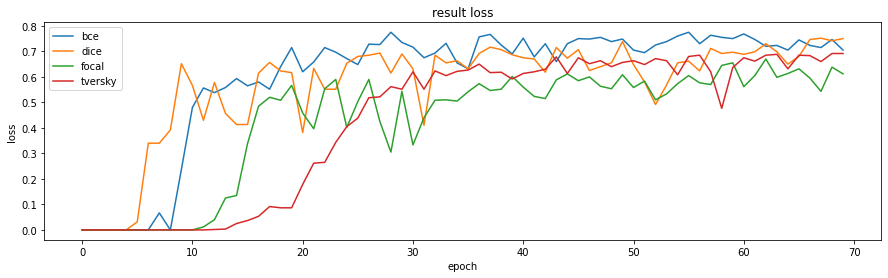

In [ ]:
  fig, ax = plt.subplots()
  plt.plot(range(len(losses['segnet_bce']['val'])),losses['segnet_bce']['test'], label='bce')
  plt.plot(range(len(losses['seg_dice']['val'])),losses['seg_dice']['test'], label='dice')
  plt.plot(range(len(losses['seg_foval']['val'])),losses['seg_foval']['test'], label='focal')
  plt.plot(range(len(losses['seg_tversky']['val'])),losses['seg_tversky']['test'], label='tversky')
  plt.legend()
  ax.set(xlabel='epoch', ylabel='loss',  title='result loss')
  plt.show()

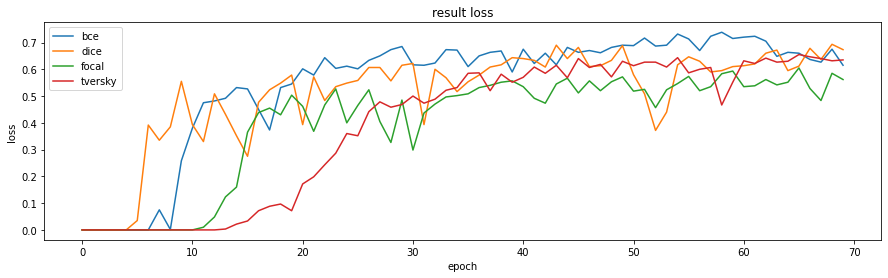

In [ ]:
  fig, ax = plt.subplots()
  plt.plot(range(len(losses['segnet_bce']['val'])),losses['segnet_bce']['score'], label='bce')
  plt.plot(range(len(losses['seg_dice']['val'])),losses['seg_dice']['score'], label='dice')
  plt.plot(range(len(losses['seg_foval']['val'])),losses['seg_foval']['score'], label='focal')
  plt.plot(range(len(losses['seg_tversky']['val'])),losses['seg_tversky']['score'], label='tversky')
  plt.legend()
  ax.set(xlabel='epoch', ylabel='loss',  title='result loss')
  plt.show()

In [ ]:
Заметим, что BCE до 60 эпохи показывает лучший результат, а затем переобучается. Исходя из наглядных граффиков в ноутбуке можно заметить, что оптимальное количество эпох для BCE - 50-60. Для Dice, tversky, focal - выше 70 эпох.

Хочу отметить, я не вывожу в отчёте отдельно данные по Score, так как они наглядно продемонстированы в 

In [ ]:
fig, ax = plt.subplots()
plt.plot(range(len(losses['unet_dice']['train'])),losses['unet_dice']['train'], label='train')
plt.plot(range(len(losses['unet_dice']['test'])),losses['unet_dice']['test'], label='test')
plt.plot(range(len(losses['unet_dice']['score'])),losses['unet_dice']['score'], label='score')
plt.plot(range(len(losses['unet_dice']['val'])),losses['unet_dice']['val'], label='val')
plt.legend()
ax.set(xlabel='epoch', ylabel='loss',  title='result loss')
plt.show()